# 필요한 모듈 설치

In [1]:
!pip install tqdm
!pip install lightgbm
!pip install easydict
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.6 MB/s eta 0:00:00


# 필요한 모듈들 import

In [2]:
# 1. 시스템 및 환경 관련 라이브러리
import os
import random
import tqdm

# 2. 데이터 분석 및 처리 라이브러리
import pandas as pd
import numpy as np
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 3. 머신러닝 관련 라이브러리
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold  # ✅ StratifiedKFold 추가
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix  # ✅ confusion_matrix 추가
from sklearn.model_selection import cross_val_score

# LightGBM 라이브러리
import lightgbm as lgb

# 날짜 및 시간 관련 라이브러리
from datetime import datetime, timezone, timedelta

# 한국 시간대 설정
kst = timezone(timedelta(hours=9))

today = datetime.now(kst).strftime('%m%d')

def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def get_submission_filename(base_path, base_filename):
    counter = 1
    submission_path = os.path.join(base_path, f"{base_filename}_{today}_{counter}.csv")
    while os.path.exists(submission_path):
        counter += 1
        submission_path = os.path.join(base_path, f"{base_filename}_{today}_{counter}.csv")
    return submission_path


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Connect to googld drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Global Variables

In [4]:
import easydict
args = easydict.EasyDict()

# path info
args.default_path = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/data/"
args.train_csv = args.default_path + "train.csv"
args.test_csv = args.default_path + "test.csv"
args.default_submission = args.default_path + "submission.csv"
args.submit_submission = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/submission_csv/"

# 결과 저장 경로 설정
history_results_dir = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/"
history_results_path = os.path.join(history_results_dir, "history_results.csv")

# 제출용
args.submission_csv = get_submission_filename(args.submit_submission, "submission")
args.submission_csv

# 기타 설정
args.random_seed = 42

# 추후의 확인을 위한 리스트
args.results = []

# Load Titanic Dataset
- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [5]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)
default_submission = pd.read_csv(args.default_submission)

ori_train.shape, ori_test.shape, default_submission.shape

((916, 12), (393, 11), (393, 2))

In [6]:
default_submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [7]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [8]:
ori_train.columns, len(ori_train.columns)

(Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
        'parch', 'ticket', 'fare', 'cabin', 'embarked'],
       dtype='object'),
 12)

In [9]:
ori_test.columns, len(ori_test.columns)

(Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
        'ticket', 'fare', 'cabin', 'embarked'],
       dtype='object'),
 11)

- test 데이터셋에는 survived가 없음을 알 수 있음
- train 데이터셋에서 훈련을 위한 데이터프레임과 검증을 위한 데이터프레임을 나눠야 함.

# model_lgbm_V0

## Train & Test Split

In [10]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [11]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

## Data Preprocessing

### Data Cleaning

In [12]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
survived,0
pclass,0
name,0
gender,0
sibsp,0
parch,0
ticket,0


In [13]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
embarked,1
passengerid,0
survived,0
pclass,0
name,0
gender,0
sibsp,0
parch,0


In [14]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
fare,1
embarked,1
passengerid,0
pclass,0
name,0
gender,0
sibsp,0
parch,0


In [15]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked에 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [16]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

<ipython-input-16-dbaadfa87f26>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-16-dbaadfa87f26>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

(580, 138, 296)

In [17]:
# print(f'before: {train.shape} / {test.shape}')
# drop_cols = ['name', 'ticket', 'cabin']

# train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
# test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
# ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

# print(f'after: {train.shape} / {test.shape}')
# train.info()

In [18]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(580, 138, 296)

### EDA

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   name         732 non-null    object 
 4   gender       732 non-null    object 
 5   age          732 non-null    float64
 6   sibsp        732 non-null    int64  
 7   parch        732 non-null    int64  
 8   ticket       732 non-null    object 
 9   fare         732 non-null    float64
 10  cabin        152 non-null    object 
 11  embarked     732 non-null    object 
 12  has_cabin    732 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 96.2+ KB


### Data Encoding & Scaling

In [20]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
        'parch', 'ticket', 'fare', 'cabin', 'embarked', 'has_cabin'],
       dtype='object'),
 13)

In [21]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형
cat_features = ['pclass', 'gender', 'embarked', 'sibsp', 'parch', 'has_cabin', 'name', 'ticket', 'cabin']

# 수치형
num_features = ['age', 'fare']

print(f"범주형 변수 개수: {len(cat_features)}, 수치형 변수 개수: {len(num_features)}")

excluded_features = set(train.columns) - set(cat_features) - set(num_features)
print(f"포함되지 않은 컬럼들: {excluded_features}")


13, 13, 12
범주형 변수 개수: 9, 수치형 변수 개수: 2
포함되지 않은 컬럼들: {'survived', 'passengerid'}


In [22]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   passengerid  732 non-null    int64   
 1   survived     732 non-null    int64   
 2   pclass       732 non-null    category
 3   name         732 non-null    category
 4   gender       732 non-null    category
 5   age          732 non-null    float64 
 6   sibsp        732 non-null    category
 7   parch        732 non-null    category
 8   ticket       732 non-null    category
 9   fare         732 non-null    float64 
 10  cabin        152 non-null    category
 11  embarked     732 non-null    category
 12  has_cabin    732 non-null    category
dtypes: category(9), float64(2), int64(2)
memory usage: 101.4 KB


## Training

### survived 분리

In [23]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

# row의 개수는 다르더라도 column의 개수은 같아야 함
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

((732, 12), (732,), (184, 12), (184,), (393, 12))

In [24]:
X_tr.isnull().sum().sum(), X_te.isnull().sum().sum(), ori_te.isnull().sum().sum()

(580, 138, 296)

In [25]:
reset_seeds()

model_name = 'model_lgbm_V0'

parameters = {
    'random_state' : args.random_seed
}

model_lgbm_V0 = lgb.LGBMClassifier(**parameters)

print(f'{model_lgbm_V0} : {X_tr.shape} / {y_tr.shape}')
model_lgbm_V0.fit(X_tr, y_tr)

LGBMClassifier(random_state=42) : (732, 12) / (732,)
[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

LGBMClassifier(random_state=42)

## Evaluation (평가)

In [26]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgbm = model_lgbm_V0.score(X_tr, y_tr)
# - Test data
score_te_lgbm = model_lgbm_V0.score(X_te, y_te)

print(f'{model_lgbm_V0} : {score_tr_lgbm}, {score_te_lgbm}')

LGBMClassifier(random_state=42) : 1.0, 0.8804347826086957


### AUC 점수

In [27]:
y_pred = model_lgbm_V0.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgbm_V0}: {auc_te}')

LGBMClassifier(random_state=42): 0.936591478696742


### 혼동행렬

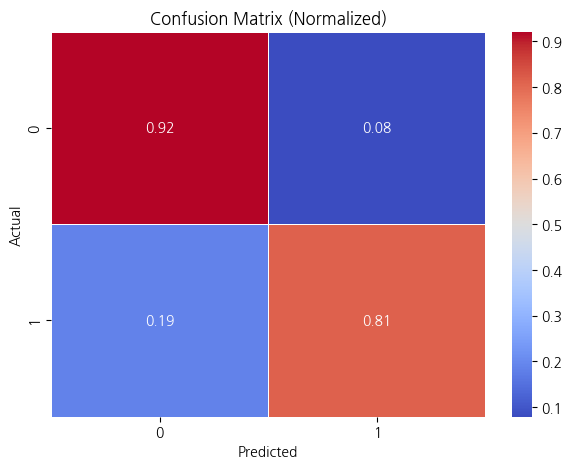

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgbm_V0.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [29]:
ori_te_pred = model_lgbm_V0.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [30]:
df_feature_importances = pd.DataFrame(model_lgbm_V0.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(12, 2)


,index,0
0,passengerid,1075
1,age,755
2,fare,743
3,pclass,107
4,gender,88
5,embarked,62
6,has_cabin,49
7,sibsp,13
8,name,0
9,parch,0


### 결과 정리

In [31]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgbm,
        'score_te': score_te_lgbm,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

# model_lgbm_V1
- V0과의 차이점 : 특성을 추가

## Train & Test Split

In [32]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [33]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [34]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

## Data Preprocessing

In [35]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   name         732 non-null    object 
 4   gender       732 non-null    object 
 5   age          597 non-null    float64
 6   sibsp        732 non-null    int64  
 7   parch        732 non-null    int64  
 8   ticket       732 non-null    object 
 9   fare         732 non-null    float64
 10  cabin        152 non-null    object 
 11  embarked     732 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 74.3+ KB


### Data Cleaning

In [37]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
survived,0
pclass,0
name,0
gender,0
sibsp,0
parch,0
ticket,0


In [38]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
embarked,1
passengerid,0
survived,0
pclass,0
name,0
gender,0
sibsp,0
parch,0


In [39]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
fare,1
embarked,1
passengerid,0
pclass,0
name,0
gender,0
sibsp,0
parch,0


In [40]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked에 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [41]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
data_list = [train, test, ori_te]
for df in data_list:
    df['age'].fillna(age_mean, inplace=True)
    df['age'].fillna(age_overall_mean, inplace=True)
    df['fare'].fillna(fare_mean, inplace=True)
    df['fare'].fillna(fare_overall_mean, inplace=True)
    df['embarked'].fillna(embarked_mode, inplace=True)
    df['has_cabin'] = df['cabin'].notnull().astype(int)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

<ipython-input-41-9bff0e5d6fdc>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(age_mean, inplace=True)
<ipython-input-41-9bff0e5d6fdc>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

(580, 138, 296)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   name         732 non-null    object 
 4   gender       732 non-null    object 
 5   age          732 non-null    float64
 6   sibsp        732 non-null    int64  
 7   parch        732 non-null    int64  
 8   ticket       732 non-null    object 
 9   fare         732 non-null    float64
 10  cabin        152 non-null    object 
 11  embarked     732 non-null    object 
 12  has_cabin    732 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 96.2+ KB


### Feature Extraction with EDA

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   name         732 non-null    object 
 4   gender       732 non-null    object 
 5   age          732 non-null    float64
 6   sibsp        732 non-null    int64  
 7   parch        732 non-null    int64  
 8   ticket       732 non-null    object 
 9   fare         732 non-null    float64
 10  cabin        152 non-null    object 
 11  embarked     732 non-null    object 
 12  has_cabin    732 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 96.2+ KB


In [44]:
data_list = [train, test, ori_te]

#### family_size: 가족 구성원 수

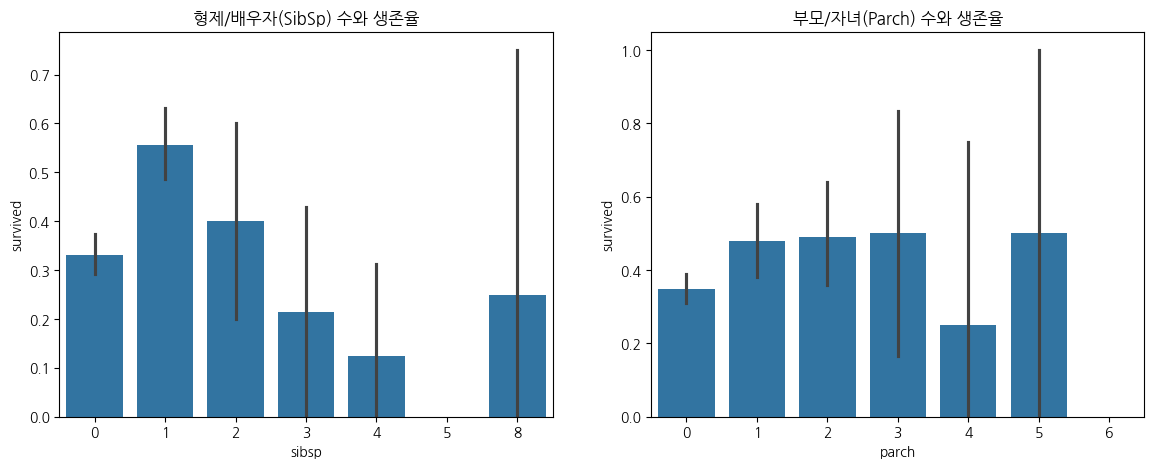

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=train["sibsp"], y=train["survived"], ax=axes[0])
axes[0].set_title("형제/배우자(SibSp) 수와 생존율")
sns.barplot(x=train["parch"], y=train["survived"], ax=axes[1])
axes[1].set_title("부모/자녀(Parch) 수와 생존율")
plt.show()

sibsp 값이 1~2인 경우 생존율이 높게 나타난다. 이는 가족과 함께한 승객이 더 높은 생존율을 가질 가능성이 있음을 시사한다.
하지만 sibsp 값이 4 이상일 때 생존율이 낮아진다. 이는 가족이 너무 많으면 구조가 어려울 수 있음을 의미한다.

parch 값이 1~2인 경우 생존율이 높게 나타난다. 이는 부모나 자녀와 동행한 승객이 더 보호받을 가능성이 있음을 시사한다.
하지만 parch 값이 4 이상일 때 생존율이 낮아진다. 이는 대가족이 구조 과정에서 불리할 수 있음을 의미한다.

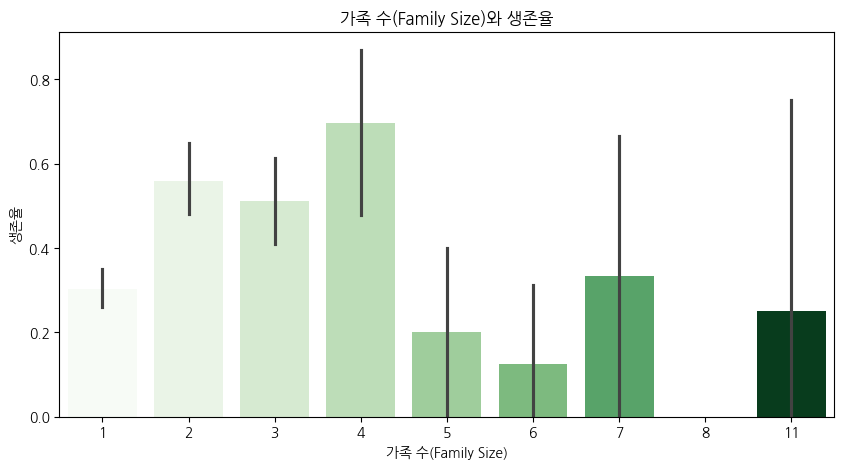

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=train["sibsp"] + train["parch"] + 1, y=train["survived"], hue=train["sibsp"] + train["parch"] + 1, palette="Greens", legend=False)
ax.set_title("가족 수(Family Size)와 생존율")
ax.set_xlabel("가족 수(Family Size)")
ax.set_ylabel("생존율")
plt.show()

In [47]:
for df in [train, test, ori_te]:
    df["family_size"] = df["sibsp"] + df["parch"] + 1

train.shape, test.shape, ori_te.shape

((732, 14), (184, 14), (393, 13))

#### pclass_gender: 객실 등급과 성별 결합

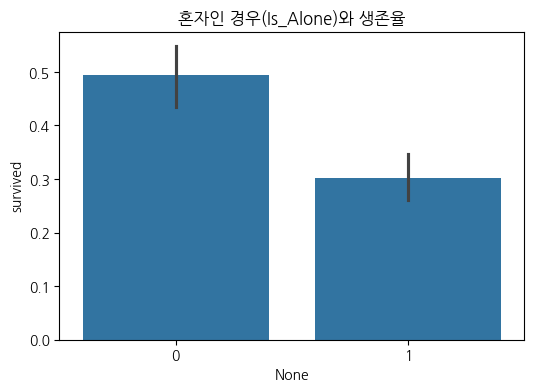

In [48]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=(train["sibsp"] + train["parch"] == 0).astype(int), y=train["survived"], ax=ax)
ax.set_title("혼자인 경우(Is_Alone)와 생존율")
plt.show()

In [49]:
for df in [train, test, ori_te]:
    df["pclass_gender"] = df["pclass"].astype(str) + "_" + df["gender"]

train.shape, test.shape, ori_te.shape

((732, 15), (184, 15), (393, 14))

#### is_alone: 혼자인지 여부

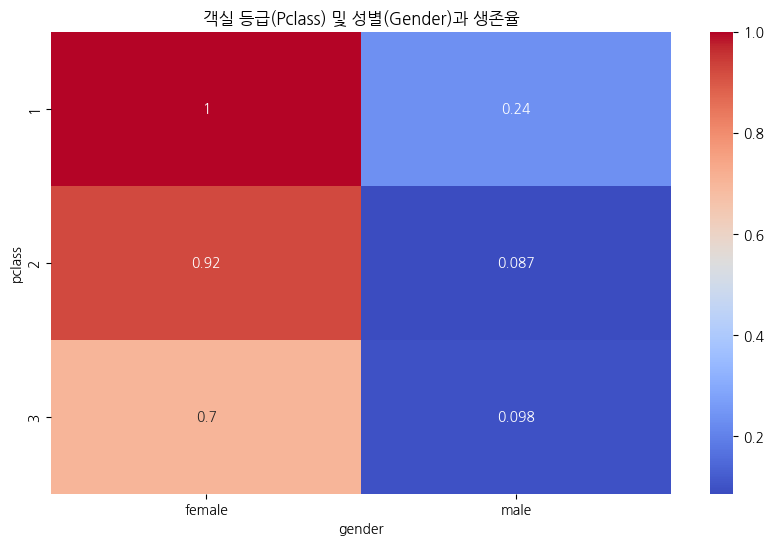

In [50]:
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(train["pclass"], train["gender"], values=train["survived"], aggfunc='mean'), annot=True, cmap='coolwarm')
plt.title("객실 등급(Pclass) 및 성별(Gender)과 생존율")
plt.show()

In [51]:
for df in [train, test, ori_te]:
    df["is_alone"] = (df["family_size"] == 1).astype(int)

train.shape, test.shape, ori_te.shape

((732, 16), (184, 16), (393, 15))

#### fare_per_person: 1인당 운임 요금

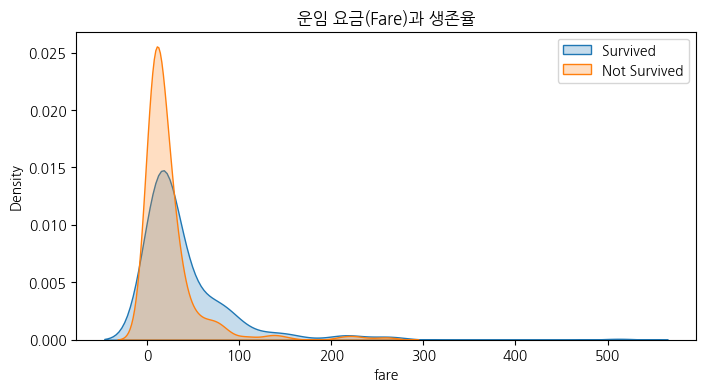

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(train[train["survived"] == 1]["fare"], label='Survived', fill=True, ax=ax)
sns.kdeplot(train[train["survived"] == 0]["fare"], label='Not Survived', fill=True, ax=ax)
ax.set_title("운임 요금(Fare)과 생존율")
ax.legend()
plt.show()

In [53]:
for df in [train, test, ori_te]:
    df["fare_per_person"] = df["fare"] / df["family_size"]
train.shape, test.shape, ori_te.shape

((732, 17), (184, 17), (393, 16))

#### title: 이름에서 호칭 추출

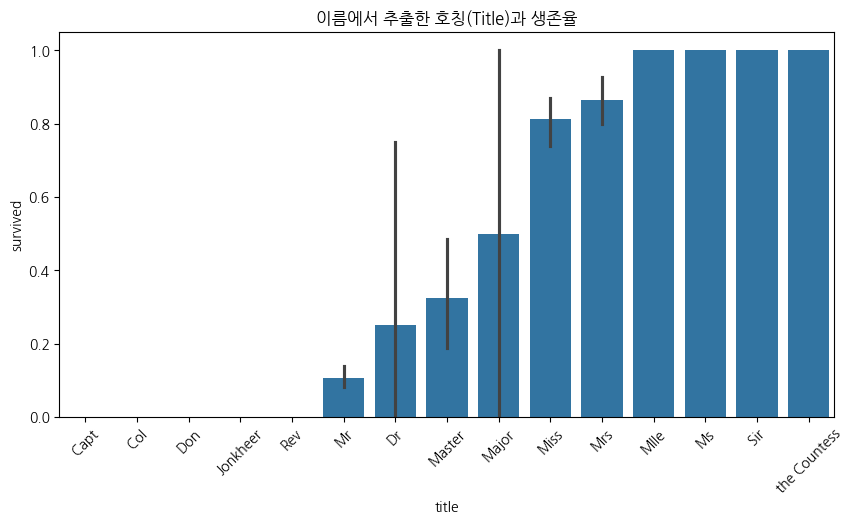

In [54]:
train["title"] = train["name"].apply(lambda x: x.split(",")[1].split(".")[0].strip() if "," in x and "." in x else "Unknown")
title_order = train.groupby("title")["survived"].mean().sort_values().index
plt.figure(figsize=(10, 5))
sns.barplot(x=train["title"], y=train["survived"], order=title_order)
plt.xticks(rotation=45)
plt.title("이름에서 추출한 호칭(Title)과 생존율")
plt.show()

In [55]:
for df in [train, test, ori_te]:
    df["title"] = df["name"].apply(lambda x: x.split(",")[1].split(".")[0].strip() if "," in x and "." in x else "Unknown")
train.shape, test.shape, ori_te.shape

((732, 18), (184, 18), (393, 17))

#### age_group: 연령 그룹화

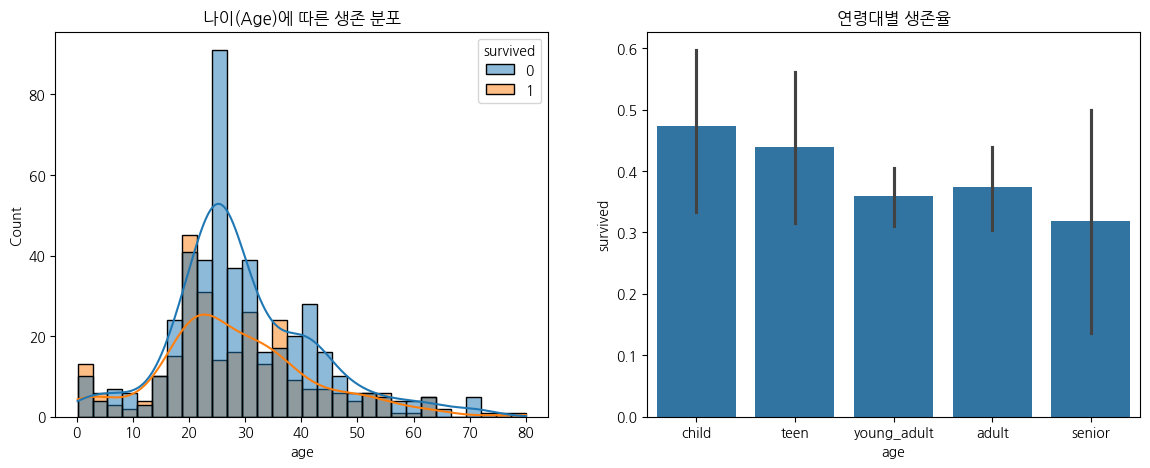

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=train, x="age", hue="survived", bins=30, kde=True, ax=axes[0])
axes[0].set_title("나이(Age)에 따른 생존 분포")
sns.barplot(x=pd.cut(train["age"], bins=[0, 12, 18, 35, 60, 100], labels=["child", "teen", "young_adult", "adult", "senior"]), y=train["survived"], ax=axes[1])
axes[1].set_title("연령대별 생존율")
plt.show()

In [57]:
for df in [train, test, ori_te]:
    df["age_group"] = pd.cut(df["age"], bins=[0, 12, 18, 35, 60, 100], labels=["child", "teen", "young_adult", "adult", "senior"])
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### embarked_fare: 탑승 항구와 운임 수준 결합

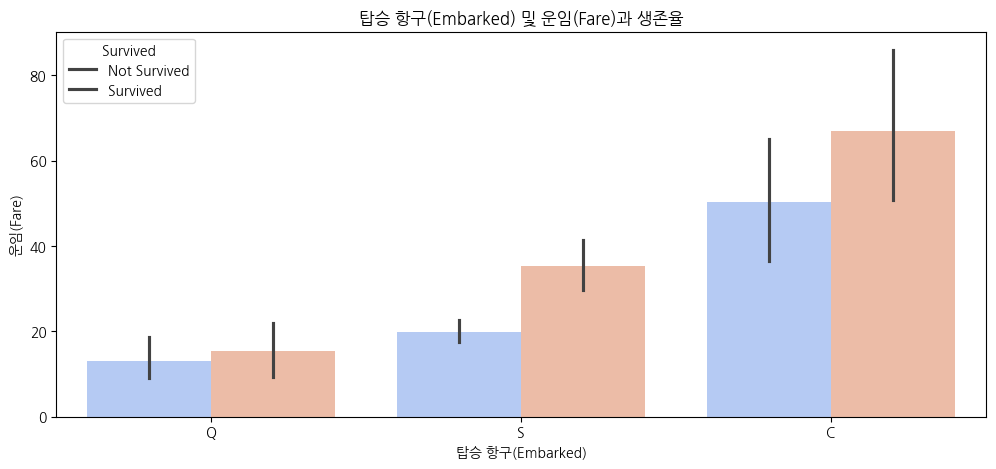

In [58]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=train["embarked"], y=train["fare"], hue=train["survived"], palette="coolwarm", ax=ax)
ax.set_title("탑승 항구(Embarked) 및 운임(Fare)과 생존율")
ax.set_xlabel("탑승 항구(Embarked)")
ax.set_ylabel("운임(Fare)")
plt.legend(title="Survived", labels=["Not Survived", "Survived"])
plt.show()

In [59]:
for df in [train, test, ori_te]:
    df["embarked_fare"] = df["embarked"].astype(str) + "_" + pd.qcut(df["fare"], 4, labels=["low", "mid-low", "mid-high", "high"], duplicates="drop").astype(str)
train.shape, test.shape, ori_te.shape

((732, 20), (184, 20), (393, 19))

#### pclass_fare_category: 객실 등급과 운임 수준 결합

In [60]:
for df in [train, test, ori_te]:
    df["pclass_fare_category"] = df["pclass"].astype(str) + "_" + pd.qcut(df["fare"], 4, labels=["low", "mid-low", "mid-high", "high"], duplicates="drop").astype(str)
train.shape, test.shape, ori_te.shape

((732, 21), (184, 21), (393, 20))

#### cabin_known: 캐빈 정보 유무 (VIP 여부 반영)

<ipython-input-61-448c47441b62>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train["cabin"].notna().astype(int), y=train["survived"], palette="viridis", ax=ax)


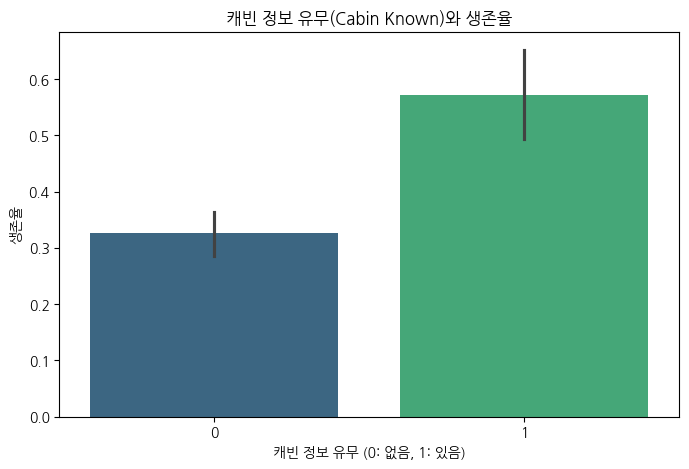

In [61]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=train["cabin"].notna().astype(int), y=train["survived"], palette="viridis", ax=ax)
ax.set_title("캐빈 정보 유무(Cabin Known)와 생존율")
ax.set_xlabel("캐빈 정보 유무 (0: 없음, 1: 있음)")
ax.set_ylabel("생존율")
plt.show()

In [62]:
for df in [train, test, ori_te]:
    df["cabin_known"] = df["cabin"].notna().astype(int)
train.shape, test.shape, ori_te.shape

((732, 22), (184, 22), (393, 21))

#### gender_family_size: 성별과 가족 크기 결합

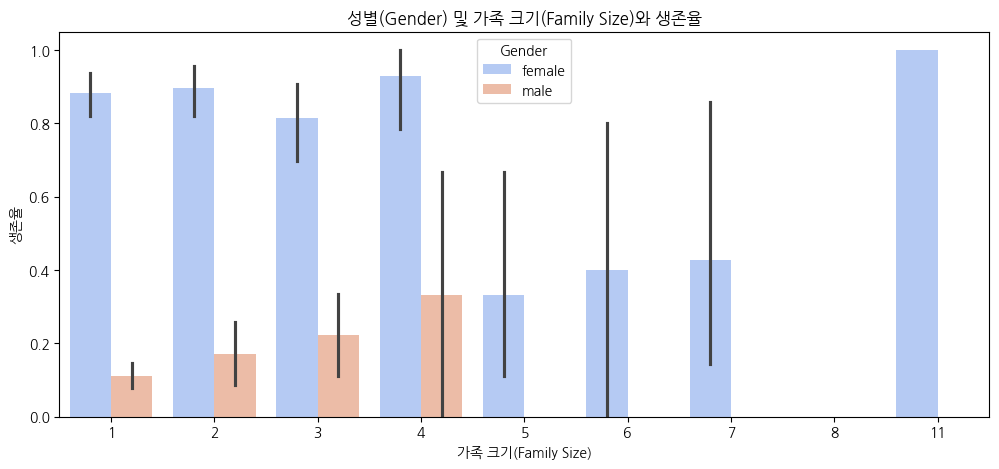

In [63]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=train["family_size"], y=train["survived"], hue=train["gender"], palette="coolwarm", ax=ax)
ax.set_title("성별(Gender) 및 가족 크기(Family Size)와 생존율")
ax.set_xlabel("가족 크기(Family Size)")
ax.set_ylabel("생존율")
plt.legend(title="Gender")
plt.show()

In [64]:
for df in [train, test, ori_te]:
    df["gender_family_size"] = df["gender"].astype(str) + "_" + df["family_size"].astype(str)
train.shape, test.shape, ori_te.shape

((732, 23), (184, 23), (393, 22))

<hr>

#### 특성 제거 (V0의 특성 중요도를 참고하여)

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    int64   
 3   name                  732 non-null    object  
 4   gender                732 non-null    object  
 5   age                   732 non-null    float64 
 6   sibsp                 732 non-null    int64   
 7   parch                 732 non-null    int64   
 8   ticket                732 non-null    object  
 9   fare                  732 non-null    float64 
 10  cabin                 152 non-null    object  
 11  embarked              732 non-null    object  
 12  has_cabin             732 non-null    int64   
 13  family_size           732 non-null    int64   
 14  pclass_gender         732 non-null    object  
 15  is_alone 

In [66]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin', 'parch']

data_list = [train, test, ori_te]
for df in data_list:
    df.drop(drop_cols, axis=1, inplace=True)

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 23) / (184, 23)
after: (732, 19) / (184, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    int64   
 3   gender                732 non-null    object  
 4   age                   732 non-null    float64 
 5   sibsp                 732 non-null    int64   
 6   fare                  732 non-null    float64 
 7   embarked              732 non-null    object  
 8   has_cabin             732 non-null    int64   
 9   family_size           732 non-null    int64   
 10  pclass_gender         732 non-null    object  
 11  is_alone              732 non-null    int64   
 12  fare_per_person       732 non-null    float64 
 13  title                 732 non-null    object  
 14  ag

In [67]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Data Encoding & Scaling

In [68]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'fare',
        'embarked', 'has_cabin', 'family_size', 'pclass_gender', 'is_alone',
        'fare_per_person', 'title', 'age_group', 'embarked_fare',
        'pclass_fare_category', 'cabin_known', 'gender_family_size'],
       dtype='object'),
 19)

In [69]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형
cat_features = [
    'pclass', 'gender', 'embarked', 'sibsp', 'has_cabin', 'pclass_gender',
    'is_alone', 'title', 'age_group', 'embarked_fare', 'pclass_fare_category',
    'cabin_known', 'gender_family_size'
]

# 수치형
num_features = ['age', 'fare', 'family_size', 'fare_per_person']

print(f"범주형 변수 개수: {len(cat_features)}, 수치형 변수 개수: {len(num_features)}")

excluded_features = set(train.columns) - set(cat_features) - set(num_features)
print(f"포함되지 않은 컬럼들: {excluded_features}")


19, 19, 18
범주형 변수 개수: 13, 수치형 변수 개수: 4
포함되지 않은 컬럼들: {'survived', 'passengerid'}


In [70]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    category
 3   gender                732 non-null    category
 4   age                   732 non-null    float64 
 5   sibsp                 732 non-null    category
 6   fare                  732 non-null    float64 
 7   embarked              732 non-null    category
 8   has_cabin             732 non-null    category
 9   family_size           732 non-null    int64   
 10  pclass_gender         732 non-null    category
 11  is_alone              732 non-null    category
 12  fare_per_person       732 non-null    float64 
 13  title                 732 non-null    category
 14  age_group             732 non-null    category
 15  embarked_

## Training

### survived 분리

In [71]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

# row의 개수는 다르더라도 column의 개수은 같아야 함
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

((732, 18), (732,), (184, 18), (184,), (393, 18))

In [72]:
X_tr.isnull().sum().sum(), X_te.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [73]:
reset_seeds()

model_name = 'model_lgbm_V1'

parameters = {
    'random_state' : args.random_seed
}

model_lgbm_V1 = lgb.LGBMClassifier(**parameters)

print(f'{model_lgbm_V1} : {X_tr.shape} / {y_tr.shape}')
model_lgbm_V1.fit(X_tr, y_tr)

LGBMClassifier(random_state=42) : (732, 18) / (732,)
[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

LGBMClassifier(random_state=42)

## Evaluation (평가)

In [74]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgbm = model_lgbm_V1.score(X_tr, y_tr)
# - Test data
score_te_lgbm = model_lgbm_V1.score(X_te, y_te)

print(f'{model_lgbm_V1} : {score_tr_lgbm}, {score_te_lgbm}')

LGBMClassifier(random_state=42) : 1.0, 0.8858695652173914


### AUC 점수

In [75]:
y_pred = model_lgbm_V1.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgbm_V1}: {auc_te}')

LGBMClassifier(random_state=42): 0.9360902255639098


### 혼동행렬

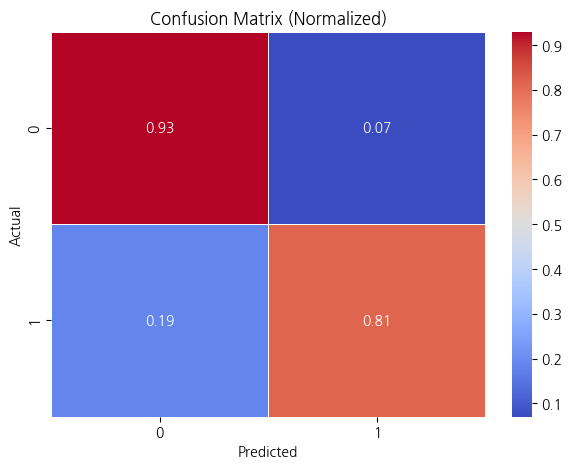

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgbm_V1.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [77]:
ori_te_pred = model_lgbm_V1.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [78]:
df_feature_importances = pd.DataFrame(model_lgbm_V1.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(18, 2)


,index,0
0,passengerid,993
1,age,619
2,fare_per_person,500
3,fare,471
4,gender,68
5,pclass,67
6,family_size,58
7,embarked,36
8,has_cabin,25
9,gender_family_size,22


### 결과 정리

In [79]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgbm,
        'score_te': score_te_lgbm,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

# model_lgbm_V2
- V1과의 차이점 : cabin_unknown을 제거, random_search 적용

## Train & Test Split

In [80]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [81]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [82]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

## Data Preprocessing

In [83]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   name         732 non-null    object 
 4   gender       732 non-null    object 
 5   age          597 non-null    float64
 6   sibsp        732 non-null    int64  
 7   parch        732 non-null    int64  
 8   ticket       732 non-null    object 
 9   fare         732 non-null    float64
 10  cabin        152 non-null    object 
 11  embarked     732 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 74.3+ KB


### Data Cleaning

In [85]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
survived,0
pclass,0
name,0
gender,0
sibsp,0
parch,0
ticket,0


In [86]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
embarked,1
passengerid,0
survived,0
pclass,0
name,0
gender,0
sibsp,0
parch,0


In [87]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
fare,1
embarked,1
passengerid,0
pclass,0
name,0
gender,0
sibsp,0
parch,0


In [88]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked에 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [89]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
data_list = [train, test, ori_te]
for df in data_list:
    df['age'].fillna(age_mean, inplace=True)
    df['age'].fillna(age_overall_mean, inplace=True)
    df['fare'].fillna(fare_mean, inplace=True)
    df['fare'].fillna(fare_overall_mean, inplace=True)
    df['embarked'].fillna(embarked_mode, inplace=True)
    df['has_cabin'] = df['cabin'].notnull().astype(int)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

<ipython-input-89-9bff0e5d6fdc>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(age_mean, inplace=True)
<ipython-input-89-9bff0e5d6fdc>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

(580, 138, 296)

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   name         732 non-null    object 
 4   gender       732 non-null    object 
 5   age          732 non-null    float64
 6   sibsp        732 non-null    int64  
 7   parch        732 non-null    int64  
 8   ticket       732 non-null    object 
 9   fare         732 non-null    float64
 10  cabin        152 non-null    object 
 11  embarked     732 non-null    object 
 12  has_cabin    732 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 96.2+ KB


### Feature Extraction with EDA

In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   name         732 non-null    object 
 4   gender       732 non-null    object 
 5   age          732 non-null    float64
 6   sibsp        732 non-null    int64  
 7   parch        732 non-null    int64  
 8   ticket       732 non-null    object 
 9   fare         732 non-null    float64
 10  cabin        152 non-null    object 
 11  embarked     732 non-null    object 
 12  has_cabin    732 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 96.2+ KB


In [92]:
data_list = [train, test, ori_te]

#### family_size: 가족 구성원 수

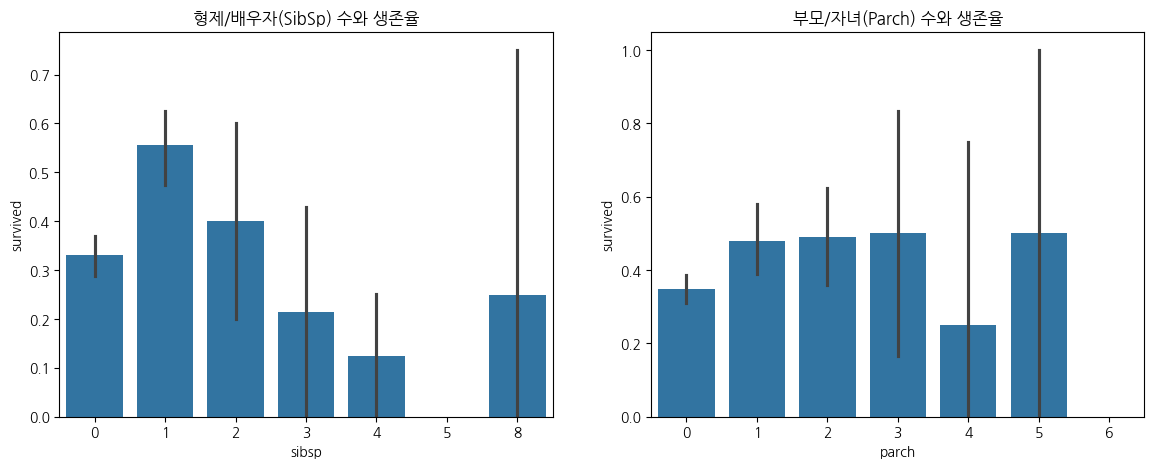

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=train["sibsp"], y=train["survived"], ax=axes[0])
axes[0].set_title("형제/배우자(SibSp) 수와 생존율")
sns.barplot(x=train["parch"], y=train["survived"], ax=axes[1])
axes[1].set_title("부모/자녀(Parch) 수와 생존율")
plt.show()

sibsp 값이 1~2인 경우 생존율이 높게 나타난다. 이는 가족과 함께한 승객이 더 높은 생존율을 가질 가능성이 있음을 시사한다.
하지만 sibsp 값이 4 이상일 때 생존율이 낮아진다. 이는 가족이 너무 많으면 구조가 어려울 수 있음을 의미한다.

parch 값이 1~2인 경우 생존율이 높게 나타난다. 이는 부모나 자녀와 동행한 승객이 더 보호받을 가능성이 있음을 시사한다.
하지만 parch 값이 4 이상일 때 생존율이 낮아진다. 이는 대가족이 구조 과정에서 불리할 수 있음을 의미한다.

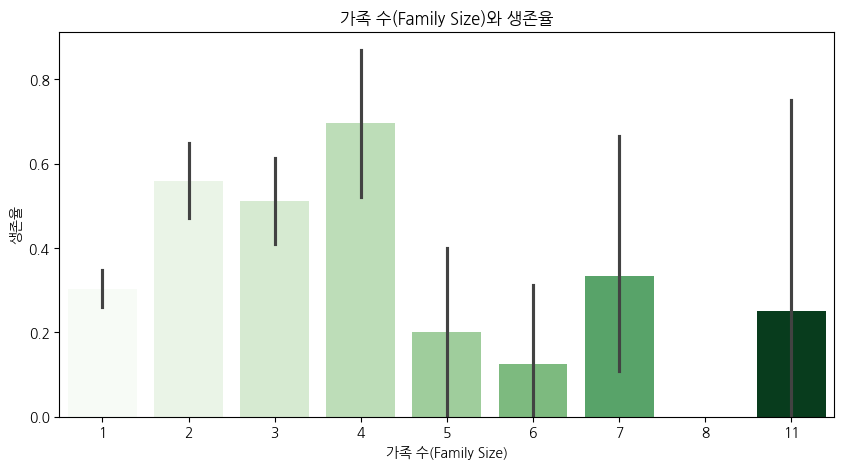

In [94]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=train["sibsp"] + train["parch"] + 1, y=train["survived"], hue=train["sibsp"] + train["parch"] + 1, palette="Greens", legend=False)
ax.set_title("가족 수(Family Size)와 생존율")
ax.set_xlabel("가족 수(Family Size)")
ax.set_ylabel("생존율")
plt.show()

In [95]:
for df in [train, test, ori_te]:
    df["family_size"] = df["sibsp"] + df["parch"] + 1

train.shape, test.shape, ori_te.shape

((732, 14), (184, 14), (393, 13))

#### pclass_gender: 객실 등급과 성별 결합

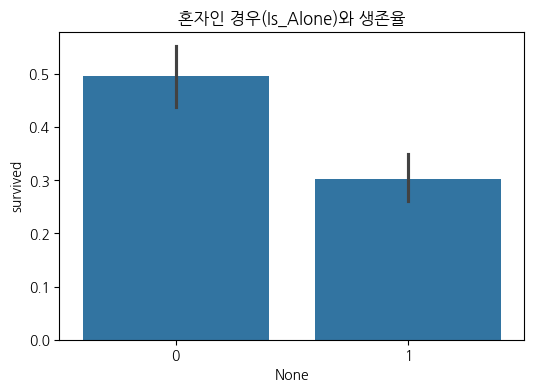

In [96]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=(train["sibsp"] + train["parch"] == 0).astype(int), y=train["survived"], ax=ax)
ax.set_title("혼자인 경우(Is_Alone)와 생존율")
plt.show()

In [97]:
for df in [train, test, ori_te]:
    df["pclass_gender"] = df["pclass"].astype(str) + "_" + df["gender"]

train.shape, test.shape, ori_te.shape

((732, 15), (184, 15), (393, 14))

#### is_alone: 혼자인지 여부

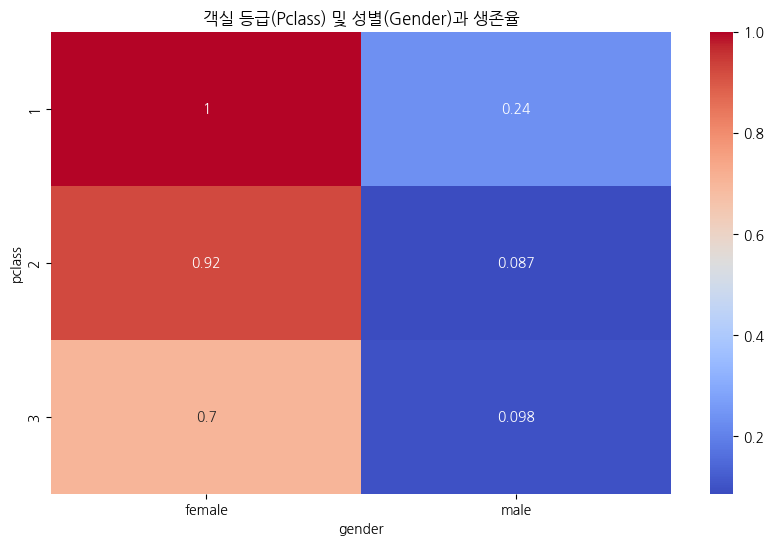

In [98]:
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(train["pclass"], train["gender"], values=train["survived"], aggfunc='mean'), annot=True, cmap='coolwarm')
plt.title("객실 등급(Pclass) 및 성별(Gender)과 생존율")
plt.show()

In [99]:
for df in [train, test, ori_te]:
    df["is_alone"] = (df["family_size"] == 1).astype(int)

train.shape, test.shape, ori_te.shape

((732, 16), (184, 16), (393, 15))

#### fare_per_person: 1인당 운임 요금

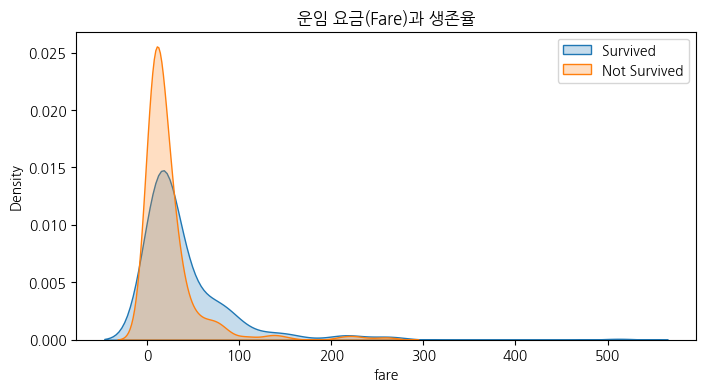

In [100]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(train[train["survived"] == 1]["fare"], label='Survived', fill=True, ax=ax)
sns.kdeplot(train[train["survived"] == 0]["fare"], label='Not Survived', fill=True, ax=ax)
ax.set_title("운임 요금(Fare)과 생존율")
ax.legend()
plt.show()

In [101]:
for df in [train, test, ori_te]:
    df["fare_per_person"] = df["fare"] / df["family_size"]
train.shape, test.shape, ori_te.shape

((732, 17), (184, 17), (393, 16))

#### title: 이름에서 호칭 추출

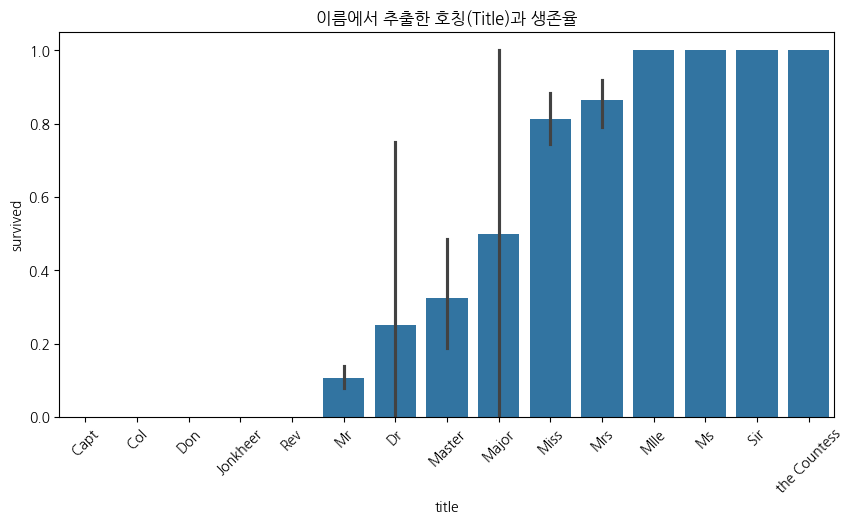

In [102]:
train["title"] = train["name"].apply(lambda x: x.split(",")[1].split(".")[0].strip() if "," in x and "." in x else "Unknown")
title_order = train.groupby("title")["survived"].mean().sort_values().index
plt.figure(figsize=(10, 5))
sns.barplot(x=train["title"], y=train["survived"], order=title_order)
plt.xticks(rotation=45)
plt.title("이름에서 추출한 호칭(Title)과 생존율")
plt.show()

In [103]:
for df in [train, test, ori_te]:
    df["title"] = df["name"].apply(lambda x: x.split(",")[1].split(".")[0].strip() if "," in x and "." in x else "Unknown")
train.shape, test.shape, ori_te.shape

((732, 18), (184, 18), (393, 17))

#### age_group: 연령 그룹화

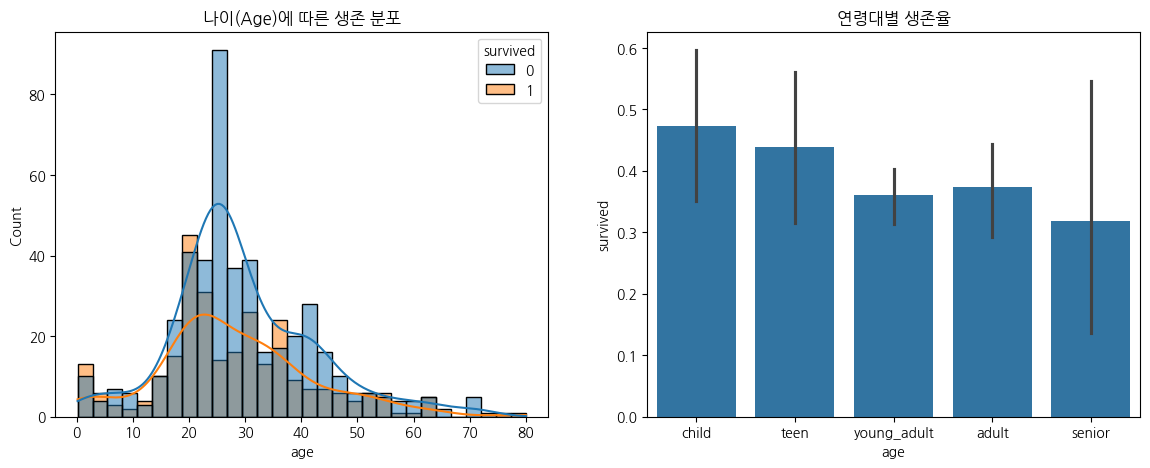

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=train, x="age", hue="survived", bins=30, kde=True, ax=axes[0])
axes[0].set_title("나이(Age)에 따른 생존 분포")
sns.barplot(x=pd.cut(train["age"], bins=[0, 12, 18, 35, 60, 100], labels=["child", "teen", "young_adult", "adult", "senior"]), y=train["survived"], ax=axes[1])
axes[1].set_title("연령대별 생존율")
plt.show()

In [105]:
for df in [train, test, ori_te]:
    df["age_group"] = pd.cut(df["age"], bins=[0, 12, 18, 35, 60, 100], labels=["child", "teen", "young_adult", "adult", "senior"])
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### embarked_fare: 탑승 항구와 운임 수준 결합

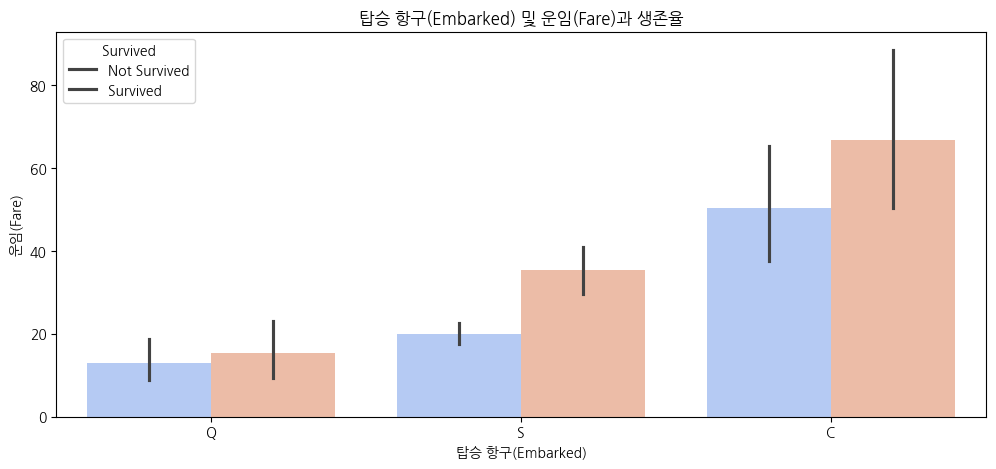

In [106]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=train["embarked"], y=train["fare"], hue=train["survived"], palette="coolwarm", ax=ax)
ax.set_title("탑승 항구(Embarked) 및 운임(Fare)과 생존율")
ax.set_xlabel("탑승 항구(Embarked)")
ax.set_ylabel("운임(Fare)")
plt.legend(title="Survived", labels=["Not Survived", "Survived"])
plt.show()

In [107]:
for df in [train, test, ori_te]:
    df["embarked_fare"] = df["embarked"].astype(str) + "_" + pd.qcut(df["fare"], 4, labels=["low", "mid-low", "mid-high", "high"], duplicates="drop").astype(str)
train.shape, test.shape, ori_te.shape

((732, 20), (184, 20), (393, 19))

#### pclass_fare_category: 객실 등급과 운임 수준 결합

In [108]:
for df in [train, test, ori_te]:
    df["pclass_fare_category"] = df["pclass"].astype(str) + "_" + pd.qcut(df["fare"], 4, labels=["low", "mid-low", "mid-high", "high"], duplicates="drop").astype(str)
train.shape, test.shape, ori_te.shape

((732, 21), (184, 21), (393, 20))

#### cabin_known: 캐빈 정보 유무 (VIP 여부 반영)

<ipython-input-109-448c47441b62>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train["cabin"].notna().astype(int), y=train["survived"], palette="viridis", ax=ax)


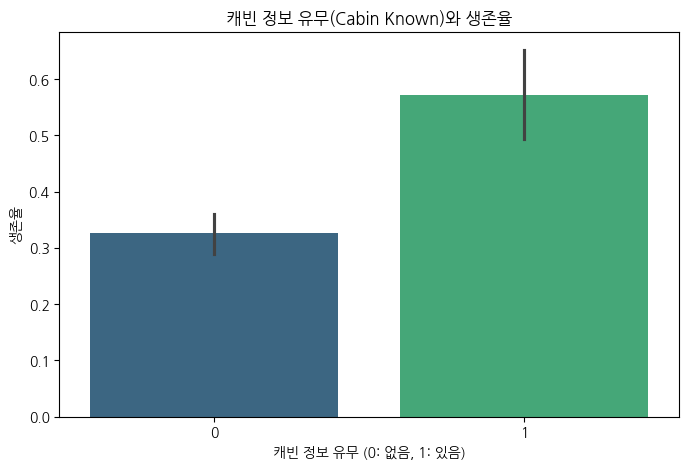

In [109]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=train["cabin"].notna().astype(int), y=train["survived"], palette="viridis", ax=ax)
ax.set_title("캐빈 정보 유무(Cabin Known)와 생존율")
ax.set_xlabel("캐빈 정보 유무 (0: 없음, 1: 있음)")
ax.set_ylabel("생존율")
plt.show()

In [110]:
for df in [train, test, ori_te]:
    df["cabin_known"] = df["cabin"].notna().astype(int)
train.shape, test.shape, ori_te.shape

((732, 22), (184, 22), (393, 21))

#### gender_family_size: 성별과 가족 크기 결합

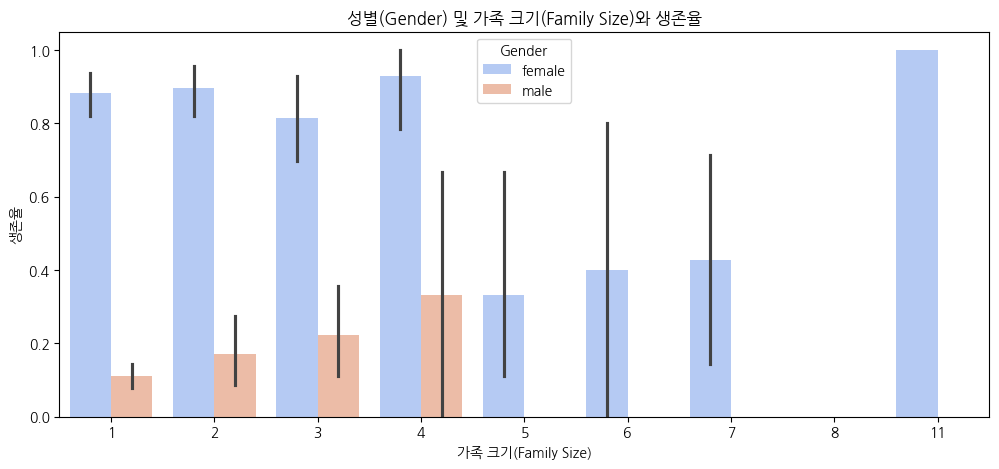

In [111]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=train["family_size"], y=train["survived"], hue=train["gender"], palette="coolwarm", ax=ax)
ax.set_title("성별(Gender) 및 가족 크기(Family Size)와 생존율")
ax.set_xlabel("가족 크기(Family Size)")
ax.set_ylabel("생존율")
plt.legend(title="Gender")
plt.show()

In [112]:
for df in [train, test, ori_te]:
    df["gender_family_size"] = df["gender"].astype(str) + "_" + df["family_size"].astype(str)
train.shape, test.shape, ori_te.shape

((732, 23), (184, 23), (393, 22))

<hr>

#### 특성 제거 (V0과 V1의 특성 중요도를 참고하여)

In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    int64   
 3   name                  732 non-null    object  
 4   gender                732 non-null    object  
 5   age                   732 non-null    float64 
 6   sibsp                 732 non-null    int64   
 7   parch                 732 non-null    int64   
 8   ticket                732 non-null    object  
 9   fare                  732 non-null    float64 
 10  cabin                 152 non-null    object  
 11  embarked              732 non-null    object  
 12  has_cabin             732 non-null    int64   
 13  family_size           732 non-null    int64   
 14  pclass_gender         732 non-null    object  
 15  is_alone 

In [114]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin', 'parch', 'cabin_known']

data_list = [train, test, ori_te]
for df in data_list:
    df.drop(drop_cols, axis=1, inplace=True)

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 23) / (184, 23)
after: (732, 18) / (184, 18)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    int64   
 3   gender                732 non-null    object  
 4   age                   732 non-null    float64 
 5   sibsp                 732 non-null    int64   
 6   fare                  732 non-null    float64 
 7   embarked              732 non-null    object  
 8   has_cabin             732 non-null    int64   
 9   family_size           732 non-null    int64   
 10  pclass_gender         732 non-null    object  
 11  is_alone              732 non-null    int64   
 12  fare_per_person       732 non-null    float64 
 13  title                 732 non-null    object  
 14  ag

In [115]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Data Encoding & Scaling

In [116]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'fare',
        'embarked', 'has_cabin', 'family_size', 'pclass_gender', 'is_alone',
        'fare_per_person', 'title', 'age_group', 'embarked_fare',
        'pclass_fare_category', 'gender_family_size'],
       dtype='object'),
 18)

In [117]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형
cat_features = [
    'pclass', 'gender', 'embarked', 'sibsp', 'has_cabin', 'pclass_gender',
    'is_alone', 'title', 'age_group', 'embarked_fare', 'pclass_fare_category', 'gender_family_size'
]

# 수치형
num_features = ['age', 'fare', 'family_size', 'fare_per_person']

print(f"범주형 변수 개수: {len(cat_features)}, 수치형 변수 개수: {len(num_features)}")

excluded_features = set(train.columns) - set(cat_features) - set(num_features)
print(f"포함되지 않은 컬럼들: {excluded_features}")


18, 18, 17
범주형 변수 개수: 12, 수치형 변수 개수: 4
포함되지 않은 컬럼들: {'survived', 'passengerid'}


In [118]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    category
 3   gender                732 non-null    category
 4   age                   732 non-null    float64 
 5   sibsp                 732 non-null    category
 6   fare                  732 non-null    float64 
 7   embarked              732 non-null    category
 8   has_cabin             732 non-null    category
 9   family_size           732 non-null    int64   
 10  pclass_gender         732 non-null    category
 11  is_alone              732 non-null    category
 12  fare_per_person       732 non-null    float64 
 13  title                 732 non-null    category
 14  age_group             732 non-null    category
 15  embarked_

## Training

### survived 분리

In [119]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

# row의 개수는 다르더라도 column의 개수은 같아야 함
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

((732, 17), (732,), (184, 17), (184,), (393, 17))

In [120]:
X_tr.isnull().sum().sum(), X_te.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [121]:
reset_seeds()

model_name = 'model_lgbm_V2'

param_grid = {
    'num_leaves': np.arange(20, 200, 10),
    'max_depth': np.arange(3, 16, 1),
    'learning_rate': np.logspace(-3, 0, 10),
    'n_estimators': np.arange(50, 1000, 50),
    'min_child_samples': np.arange(5, 100, 5),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'reg_alpha': np.logspace(-3, 1, 10),
    'reg_lambda': np.logspace(-3, 1, 10)
}

# 기본 설정
parameters = {'random_state': args.random_seed}

# 모델 생성
model_lgbm_V2 = lgb.LGBMClassifier(**parameters)

# StratifiedKFold 설정
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=args.random_seed)

# Randomized Search 적용
random_search = RandomizedSearchCV(estimator=model_lgbm_V2, param_distributions=param_grid, n_iter=200,
                                   scoring='roc_auc', cv=stratified_kfold, verbose=2, n_jobs=-1, random_state=args.random_seed)

# 모델 학습
random_search.fit(X_tr, y_tr)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(random_state=42), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'max_depth': array([ 3,  4,  5,  6...
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01]),
                                        'reg_lambda': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='roc_auc', verbose=2)

In [122]:
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")
print(f"Best AUC Score from Randomized Search: {random_search.best_score_}")

Best Parameters: {'subsample': 0.5, 'reg_lambda': 0.001, 'reg_alpha': 3.593813663804626, 'num_leaves': 80, 'n_estimators': 300, 'min_child_samples': 25, 'max_depth': 7, 'learning_rate': 0.004641588833612777, 'colsample_bytree': 1.0}
Best AUC Score from Randomized Search: 0.9083267195767194


In [123]:
reset_seeds()

parameters = best_params

# 최적 하이퍼파라미터를 적용하여 모델 생성
model_lgbm_V2 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

# 최적 모델 학습
model_lgbm_V2.fit(X_tr, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(learning_rate=0.004641588833612777, max_depth=7,
               min_child_samples=25, n_estimators=300, num_leaves=80,
               random_state=42, reg_alpha=3.593813663804626, reg_lambda=0.001,
               subsample=0.5)

In [124]:
# reset_seeds()

# model_name = 'model_lgbm_V2'

# parameters = {
#     'random_state' : args.random_seed
# }

# model_lgbm_V2 = lgb.LGBMClassifier(**parameters)

# print(f'{model_lgbm_V2} : {X_tr.shape} / {y_tr.shape}')
# model_lgbm_V2.fit(X_tr, y_tr)

## Evaluation (평가)

In [125]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgbm = model_lgbm_V2.score(X_tr, y_tr)
# - Test data
score_te_lgbm = model_lgbm_V2.score(X_te, y_te)

print(f'{model_lgbm_V2} : {score_tr_lgbm}, {score_te_lgbm}')

LGBMClassifier(learning_rate=0.004641588833612777, max_depth=7,
               min_child_samples=25, n_estimators=300, num_leaves=80,
               random_state=42, reg_alpha=3.593813663804626, reg_lambda=0.001,
               subsample=0.5) : 0.8729508196721312, 0.875


### AUC 점수

In [126]:
y_pred = model_lgbm_V2.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgbm_V2}: {auc_te}')

LGBMClassifier(learning_rate=0.004641588833612777, max_depth=7,
               min_child_samples=25, n_estimators=300, num_leaves=80,
               random_state=42, reg_alpha=3.593813663804626, reg_lambda=0.001,
               subsample=0.5): 0.9261278195488722


### 혼동행렬

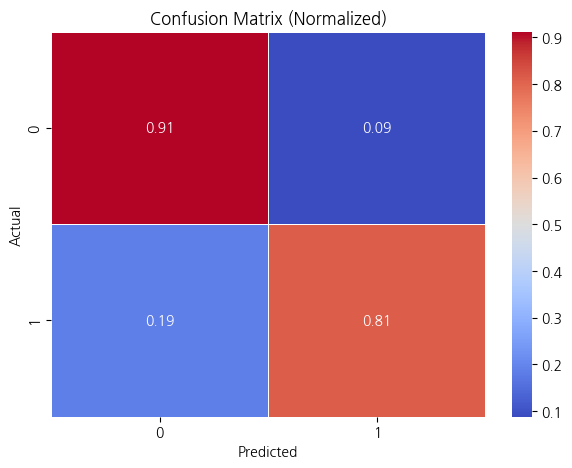

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgbm_V2.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [128]:
ori_te_pred = model_lgbm_V2.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [129]:
df_feature_importances = pd.DataFrame(model_lgbm_V2.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(17, 2)


,index,0
0,fare_per_person,593
1,passengerid,457
2,gender,300
3,age,290
4,pclass,130
5,family_size,95
6,has_cabin,84
7,embarked,0
8,fare,0
9,pclass_gender,0


### 결과 정리

In [130]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgbm,
        'score_te': score_te_lgbm,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

# Submission

In [131]:
default_submission = pd.read_csv(args.default_submission)
default_submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [132]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt,score_diff,auc_diff,total_diff
2,model_lgbm_V2,"{'subsample': 0.5, 'reg_lambda': 0.001, 'reg_a...",0.872951,0.875000,0.926128,"[0.6501316816231575, 0.7442392682307839, 0.654...",17,"[fare_per_person, passengerid, gender, age, pc...",2025-02-14 00:44:14,0.002049,0.051128,0.053177
1,model_lgbm_V1,{'random_state': 42},1.000000,0.885870,0.936090,"[0.875244414170572, 0.9662680268490565, 0.8084...",18,"[passengerid, age, fare_per_person, fare, gend...",2025-02-14 00:39:57,0.114130,0.050221,0.164351
0,model_lgbm_V0,{'random_state': 42},1.000000,0.880435,0.936591,"[0.9649260056223699, 0.890285496277456, 0.8973...",12,"[passengerid, age, fare, pclass, gender, embar...",2025-02-14 00:39:52,0.119565,0.056157,0.175722


In [133]:
default_submission['survived'] = df_results.iloc[0]['ori_te_pred']

# 결측값 확인 및 결과 출력
print(f'{default_submission.isnull().sum().sum()}')
default_submission.head(10)

0


,passengerid,survived
0,916,0.650132
1,917,0.744239
2,918,0.654104
3,919,0.219117
4,920,0.744239
5,921,0.744239
6,922,0.219117
7,923,0.219117
8,924,0.654104
9,925,0.219117


In [134]:
default_submission.to_csv(args.submission_csv, header=True, index=False)

In [135]:
# 방금 제출한 csv 파일의 파일명 출력
submission_filename = os.path.basename(args.submission_csv)
print(submission_filename)

submission_0214_2.csv
